In [25]:
#importing all the required libraries

import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
import pickle

# Undistorting the images
Read all the input images for calibrating the camera images.

In [17]:
def read_calib_images():
    input_images = glob.glob('camera_cal/*.jpg')
    calib_imgs = []

    for file in input_images:
        img = mpimg.imread(file)
        calib_imgs.append(img)
        
    return calib_imgs

def read_test_images():
    input_images = glob.glob('test_images/*.jpg')
    test_imgs = []

    for file in input_images:
        img = mpimg.imread(file)
        test_imgs.append(img)
        
    return test_imgs


Function to find corners in chess board, and seperate the images in which the corners cannot be detected

In [3]:
def find_corners(imgs, nx, ny):
    objpoints = [] #3D points
    imgpoints = [] #2D points
    
    corners_not_detected = [] #list of images in which corners cannot be detected
    corners_detected = [] #list of images in which corners were detected
    
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)
    
    for img in imgs:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        ret, corners = cv2.findChessboardCorners(gray_img, (nx, ny), None)
        
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            corners_detected.append(img)
        else:
            corners_not_detected.append(img)
            
    return objpoints, imgpoints, corners_detected, corners_not_detected

Testing the functionality of Corners detected and not detected in the list of input images

Number of images in which corners were detected =  17
Number of images in which corners were not detected =  3

images of corners detected


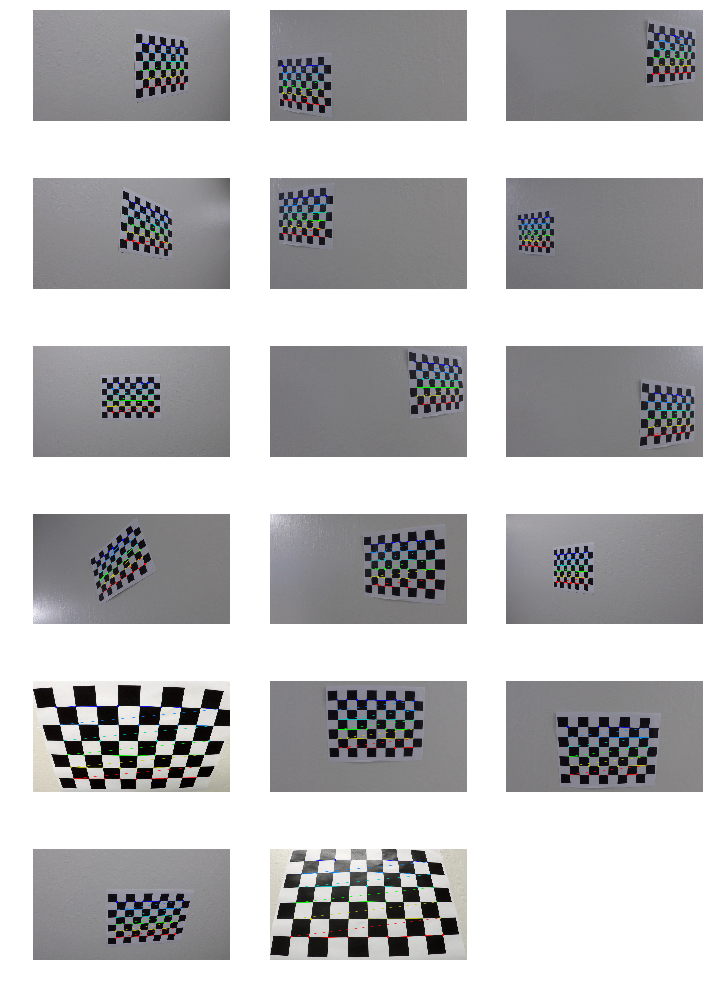


images of corners not detected


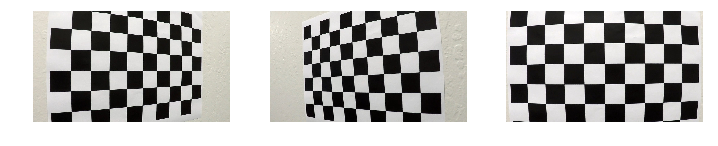

In [4]:
#Number of corners to be found
nx = 9
ny = 6

calib_imgs = read_calib_images()
objpoints, imgpoints, corners_detected, corners_not_detected = find_corners(calib_imgs, nx, ny)

print("Number of images in which corners were detected = ", len(corners_detected))
print("Number of images in which corners were not detected = ", len(corners_not_detected))

# view the images
print("")
print("images of corners detected")
plt.figure(figsize=(12, 18))
for idx, img in enumerate(corners_detected):
    cv2.drawChessboardCorners(img, (nx,ny), imgpoints[idx], True)
    plt.subplot(6, 3, idx+1)
    plt.imshow(img)
    plt.axis('off')    
plt.show()

print("")
print("images of corners not detected")
plt.figure(figsize=(12, 3))
for idx, img in enumerate(corners_not_detected):
    plt.subplot(1, 3, idx+1)
    plt.imshow(img)
    plt.axis('off')    
plt.show()



Since the number of x and y corners to be detected is more than the number of corners that could be observed in the previous 3 images, it is classified as not detected

Function to undistort an image

In [23]:
def get_calibration_value(img, objpoints, imgpoints):
    
    img_shape = (img.shape[0], img.shape[1])
    
    #calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
    return mtx, dist

def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

Testing the functionality of undistortion

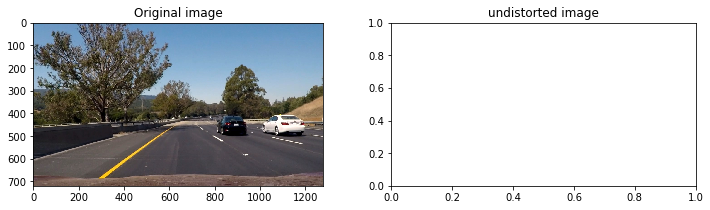

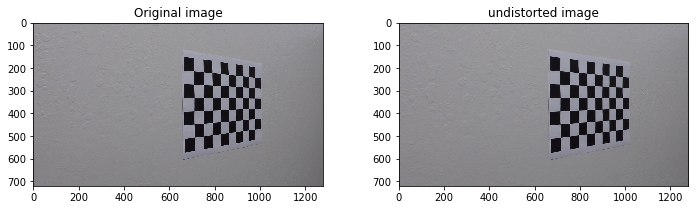

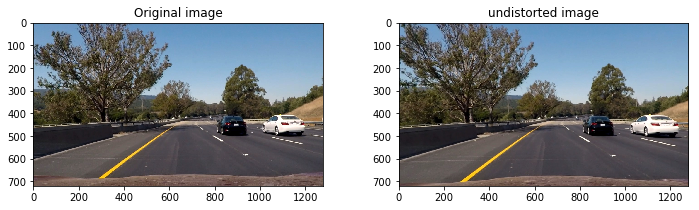

In [27]:
nx = 9
ny = 6

calib_imgs = read_calib_images()
objpoints, imgpoints, corners_detected, corners_not_detected = find_corners(calib_imgs, nx, ny)

mtx, dist = get_calibration_value(corners_detected[0], objpoints, imgpoints)

calibration_value = {}
calibration_value["mtx"] = mtx
calibration_value["dist"] = dist
pickle.dump( calibration_value, open( "calibration_value.p", "wb" ) )

undist_img = undistort_img(corners_detected[0], mtx, dist)

plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(corners_detected[0])
plt.subplot(1,2,2)
plt.title("undistorted image")
plt.imshow(undist_img)
plt.show()

img = mpimg.imread('test_images/test6.jpg')
plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
plt.title("Original image")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("undistorted image")
plt.imshow(undistort_img(img, mtx, dist))
plt.show()

# Pipeline for lane detection
Convert the images to binary format

In [7]:
def convert_to_binary(img, sobel_thresh=(25,255), s_thresh=(100, 255), l_thresh=(35,255)):
    
    raw_img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(raw_img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((binary,binary,binary)).astype('uint8')            
    return binary

Testing the binary functionality

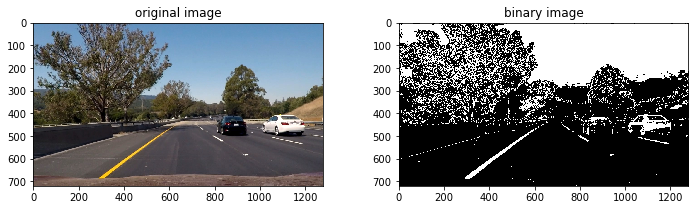

In [8]:
img = mpimg.imread('test_images/test6.jpg')

binary = convert_to_binary(img)
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(binary)
plt.title("binary image")
plt.show()

Warping the images

In [60]:
# depending on the requirement of top view or camera view, warp the image
def img_warp(img, top_view=True):
    
    corners = np.float32([[190,720],[590,455],[700,455],[1145,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])
    
    img_shape = (img.shape[1], img.shape[0])
    
    if top_view:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
        
    warped_img = cv2.warpPerspective(img, M, img_shape, flags=cv2.INTER_LINEAR)
    
    return warped_img

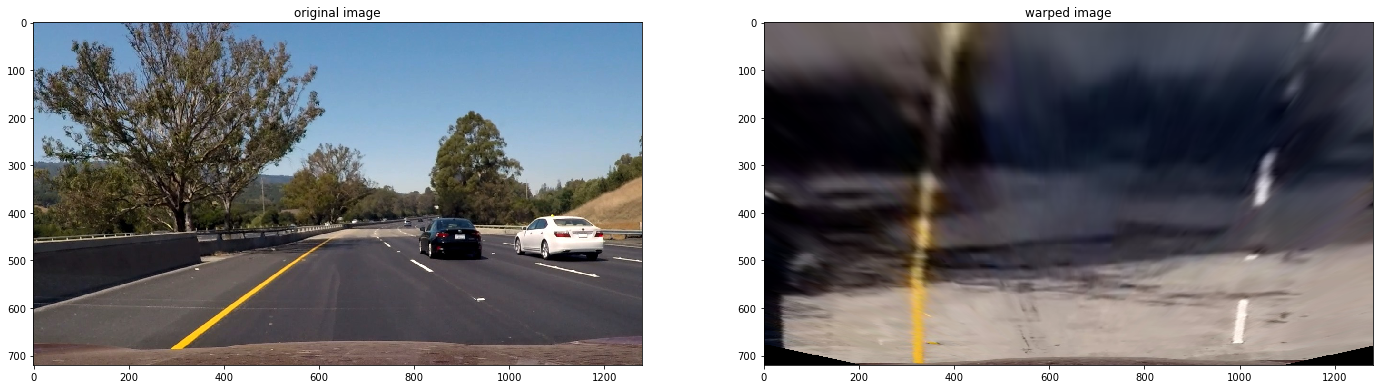

In [59]:
test_imgs = read_test_images()

with open('calibration_value.p', mode='rb') as f:
    calibration_value = pickle.load(f)
    mtx = calibration_value["mtx"]
    dist = calibration_value["dist"]

undist_img = undistort_img(test_imgs[1], mtx, dist)
warped_img = img_warp(undist_img)
plt.figure(figsize=(24,9))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(warped_img)
plt.title("warped image")
plt.show()

In [72]:
def img_msk(img):
    points = np.array([[(0,0),(img.shape[1],0),(img.shape[1],0), (6 * img.shape[1]/7, img.shape[0]),
                      (img.shape[1]/7, img.shape[0]), (0,0)]],dtype=np.int32)
    msk = np.zeros_like(img)
    
    no_of_channels = img.shape[2]
    msk_color = (255, ) * no_of_channels
    
    #filling pixels inside the polygon defined by "points" with the fill color    
    cv2.fillPoly(msk, points, msk_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, msk)
    return masked_image

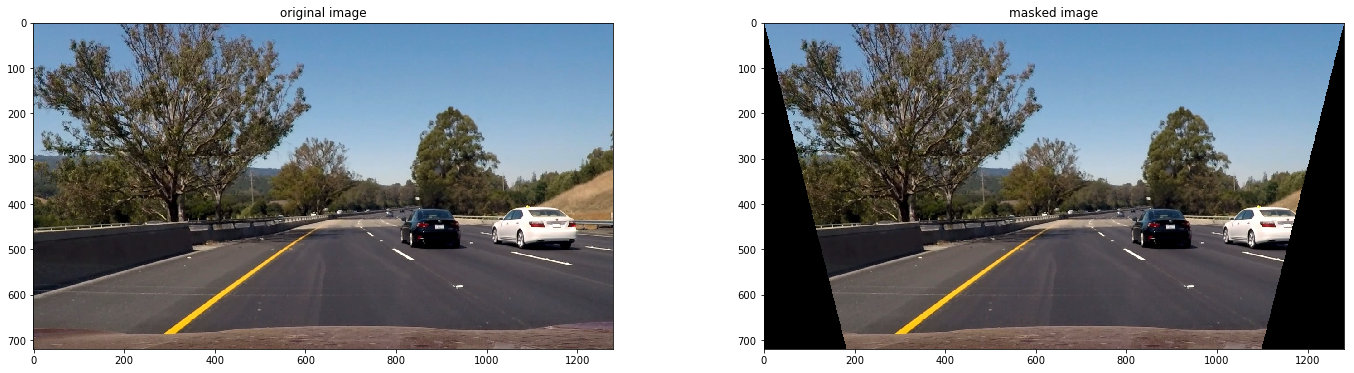

In [74]:
test_imgs = read_test_images()
msk_img = img_msk(test_imgs[3])

plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(test_imgs[3])
plt.subplot(1,2,2)
plt.imshow(msk_img)
plt.title("masked image")
plt.show()

Pipeline functionality

In [75]:
def warp_pipe(img, mtx, dist):
    undist_img = undistort_img(img, mtx, dist)
    bin_img = convert_to_binary(undist_img)
    warp_img = img_warp(bin_img)
    msked_img = img_msk(warp_img)
    
    return msked_img

Testing the warp pipeline

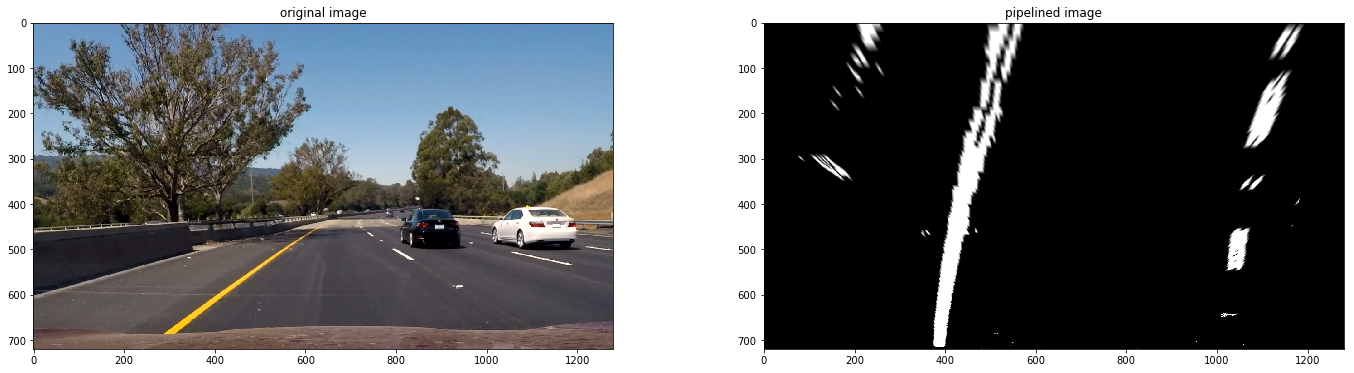

In [79]:
test_imgs = read_test_images()

with open('calibration_value.p', mode='rb') as f:
    calibration_value = pickle.load(f)
    mtx = calibration_value["mtx"]
    dist = calibration_value["dist"]
    
msk_img = warp_pipe(test_imgs[3], mtx, dist)


plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.title("original image")
plt.imshow(test_imgs[3])
plt.subplot(1,2,2)
plt.imshow(msk_img)
plt.title("pipelined image")
plt.show()

In [80]:
def draw_lane(img):
    leftx, lefty, rightx, righty = histogram_pixels(warped, horizontal_offset=horizontal_offset)

    # Fit a second order polynomial to each fake lane line
    left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
    print("Left coeffs:", left_coeffs)
    print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
    right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
    print("Right coeffs: ", right_coeffs)

    # Plot data

    plt.plot(left_fit, lefty, color='green', linewidth=3)
    plt.plot(right_fit, righty, color='green', linewidth=3)
    plt.imshow(warped, cmap="gray")